In [92]:
import os
from os import listdir
from os.path import isfile, join
import random

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

import numpy as np

from PIL import Image as PImage

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy, MeanSquaredError, R2Score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as trf
import torchvision.models as models
import torchvision

import warnings

In [108]:
params = {
    "path_dataset": "./dataset",
    "lr": 0.0001,
    "batch_size": 4,
    "num_workers": 4,
    "epochs": 5,
}

In [3]:
path_class_dataset = [x[0] for x in os.walk(params['path_dataset']) if x[0] != params['path_dataset']]
dataset = [[(e.split('/')[-1], os.path.join(e, f)) for f in listdir(e) if isfile(join(e, f))] for e in path_class_dataset]

In [4]:
dataset

[[('Есть', './dataset/Есть/img_330030.jpg'),
  ('Есть', './dataset/Есть/img_308235.jpg'),
  ('Есть', './dataset/Есть/img_233325.jpg'),
  ('Есть', './dataset/Есть/img_280830.jpg'),
  ('Есть', './dataset/Есть/img_310380.jpg'),
  ('Есть', './dataset/Есть/img_313485.jpg'),
  ('Есть', './dataset/Есть/img_178125.jpg'),
  ('Есть', './dataset/Есть/img_355515.jpg'),
  ('Есть', './dataset/Есть/img_244290.jpg'),
  ('Есть', './dataset/Есть/img_157695.jpg'),
  ('Есть', './dataset/Есть/img_177015.jpg'),
  ('Есть', './dataset/Есть/img_306360.jpg'),
  ('Есть', './dataset/Есть/img_306510.jpg'),
  ('Есть', './dataset/Есть/img_304050.jpg'),
  ('Есть', './dataset/Есть/img_143880.jpg'),
  ('Есть', './dataset/Есть/img_175305.jpg'),
  ('Есть', './dataset/Есть/img_153345.jpg'),
  ('Есть', './dataset/Есть/img_276330.jpg'),
  ('Есть', './dataset/Есть/img_364620.jpg'),
  ('Есть', './dataset/Есть/img_329100.jpg'),
  ('Есть', './dataset/Есть/img_176670.jpg'),
  ('Есть', './dataset/Есть/img_172680.jpg'),
  ('Есть',

In [5]:
train = []
test = []

set_true = set([idx for idx in range(len(dataset[0]))])
set_false = set([idx for idx in range(len(dataset[1]))])

len_test_true = int(len(dataset[0]) * 0.1)
len_test_false = int(len(dataset[1]) * 0.1)
    
len_test_true, len_test_false

(955, 2812)

In [6]:
for pos in range(len_test_true):
    set_true -= set([pos]) 
    test.append((0, pos))
for idx in set_true:
    train.append((0, idx))
for pos in range(len_test_false):
    set_false -= set([pos]) 
    test.append((1,pos))
for idx in set_false:
    train.append((1, idx))
train = [dataset[idx[0]][idx[1]] for idx in train]
test = [dataset[idx[0]][idx[1]] for idx in test]

In [37]:
class DlibDisplaysDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.dto = list(np.unique([e[0] for e in data]))
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = torch.from_numpy(np.array([[float(self.dto.index(data[0]))]]))
        #label = torch.from_numpy(np.array([float(1 if self.dto.index(data[0]) == idx else 0) for idx in range(2)]))
        img = PImage.open(data[1])
        image = self.transform(img)
        
        return image, label

In [75]:
torch_transform_train = trf.Compose([
    trf.RandomRotation(3.0),
    trf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.05, hue=0.05), 
    trf.Grayscale(num_output_channels=1),
    trf.ToTensor(),
    trf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

torch_transform_test = trf.Compose([
    trf.Grayscale(num_output_channels=1),
    trf.ToTensor(),
    trf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
dataset_train = DlibDisplaysDataset(train, torch_transform_train)
dataset_test = DlibDisplaysDataset(test, torch_transform_test)
train_loader = DataLoader(
    dataset_train, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=False,
)
test_loader = DataLoader(
    dataset_test, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=False,
)

In [76]:
np.shape(dataset_train[-1][0])

torch.Size([3, 116, 116])

In [93]:
class Network(nn.Module):
    def __init__(self, emb_dim=116):
        super(Network, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 32, 5),
        )
        self.conv_2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
        )
        self.conv_3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5),
        )
        self.conv_4 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, 5),
        )
        self.conv_5 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
        )
        
        self.fc_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.Linear(512, 256),
            #nn.PReLU(),
        )        
        self.fc_2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Linear(128, 1),
            #nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = self.conv_5(x)
        
        x = F.relu(self.fc_1(x))
        x = F.sigmoid(self.fc_2(x))
        return x

In [112]:
model = Network()

In [113]:
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=params['lr'])#1e-3)

In [114]:
def calculate_accuracy_(output, target):
    return 1 - np.mean(np.abs(target.detach().numpy()  - output.detach().numpy() ))

In [115]:
def r2_score(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    f = m * x + c
    yminusf2 = (y - f)**2
    sserr = sum(yminusf2)
    mean = float(sum(y)) / float(len(y))
    yminusmean2 = (y - mean)**2
    sstot = sum(yminusmean2)
    return 1. -(sserr / sstot)

In [116]:
warnings.filterwarnings("ignore")

In [117]:
hirtory_loss = []
histort_acc_train = []
history_acc_test = []
accuracy = Accuracy()
mse = MeanSquaredError()

for epoch in tqdm_step(range(params['epochs']), desc="Epochs"):
    loss = 0
    len_ = 0
    running_corrects = 0.0
    for batch_features, labels in tqdm_step(train_loader, desc="Training", leave=False): 
            outputs = model(batch_features)
            #print(outputs)
            #print(labels)
            train_loss = criterion(outputs, labels.float())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()
            running_corrects += calculate_accuracy_(outputs, labels)
            len_ += len(outputs)
            #break
    
    epoch_acc = running_corrects / (len_ / params["batch_size"])
    histort_acc_train.append(histort_acc_train)
    loss /= len(train_loader)
    hirtory_loss.append(loss)
    
    tests_acc_1 = 0.0
    tests_mse = 0.0
    y_pred = []
    y_true = []
    for batch_features, labels in tqdm_step(test_loader, desc="Testing", leave=False):
        y_pred.append(float(int(model(batch_features).detach().numpy()[0][0] > 0.6)))
        y_true.append(labels.numpy()[0][0])
    
    y_pred = np.array(np.vstack(y_pred))
    y_true = np.array(np.vstack(y_true))
    tests_acc_1 = calculate_accuracy_(torch.tensor(y_pred), torch.tensor(y_true))
    tests_mse = mean_squared_error(y_true, y_pred, squared=False)
    history_acc_test.append(tests_acc_1)
    print("epoch : {}/{}, loss = {:.8f} Training acc: {:.6f}, Testing acc:{:.6f}, mse:{:.6f}".format(epoch + 1, params['epochs'], loss, epoch_acc, tests_acc_1, tests_mse))

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/8479 [00:00<?, ?it/s]

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

epoch : 1/5, loss = 0.18167504 Training acc: 0.639656, Testing acc:0.749469, mse:0.500531


Training:   0%|          | 0/8479 [00:00<?, ?it/s]

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

epoch : 2/5, loss = 0.18022932 Training acc: 0.640848, Testing acc:0.755839, mse:0.494127


Training:   0%|          | 0/8479 [00:00<?, ?it/s]

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

epoch : 3/5, loss = 0.17884891 Training acc: 0.642853, Testing acc:0.748408, mse:0.501590


Training:   0%|          | 0/8479 [00:00<?, ?it/s]

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

epoch : 4/5, loss = 0.17849006 Training acc: 0.643367, Testing acc:0.737792, mse:0.512063


Training:   0%|          | 0/8479 [00:00<?, ?it/s]

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

epoch : 5/5, loss = 0.17919434 Training acc: 0.642019, Testing acc:0.751592, mse:0.498405


In [123]:
y_pred = []
y_true = []
for batch_features, labels in tqdm_step(test_loader, desc="Testing", leave=False):
    y_pred.append(float(int(model(batch_features).detach().numpy()[0][0] > 0.6)))
    y_true.append(labels.numpy()[0][0])
y_pred = np.array(np.vstack(y_pred))
y_true = np.array(np.vstack(y_true))

Testing:   0%|          | 0/942 [00:00<?, ?it/s]

In [129]:
np.shape(y_pred[:,0]), np.shape(y_true[:,0])

((942,), (942,))

In [130]:
confusion_matrix(y_true, y_pred)

array([[245,  15],
       [  0, 682]])

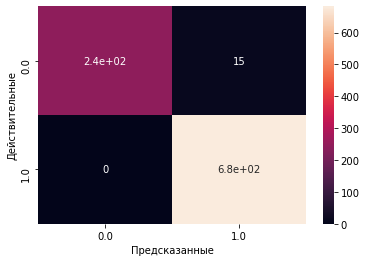

In [133]:
conf_matrix = pd.crosstab(pd.Series(y_true[:,0]), pd.Series(y_pred[:,0]), rownames=['Действительные'], colnames=['Предсказанные'])

sn.heatmap(conf_matrix, annot=True)
plt.show()

In [139]:
f"Точность сотавляет на тестовой выборки {round(calculate_accuracy_(torch.tensor(np.array(y_true)), torch.tensor(np.array(y_pred))), 3)*100}%"

'Точность сотавляет на тестовой выборки 98.4%'